# Himalayan Mountaineering Analysis
## CPSC 322
## Fall, 2022
### Jaymin West, Dominic MacIsaac
---------------------------------------------------------

### Introduction:

The dataset that we chose to use for this project involves reports from expeditions that have the goal of reaching summits in the Himalayan Mountains. Each instance has a great deal of information about the specific expedition and we expcet this will give us some insight into what it takes to reach the summit of these extreme mountains.

After our data cleaning and preparation, we used our Naive Bayes, Decision Tree, and Random Forest classifiers to try and predict the result of the expeditions. In the end, our Random Forest Classifier performed the best of all them.  

#### About The Dataset

**Source**

https://www.himalayandatabase.com

Complete Data (With unnecessary attribute columns removed): 

https://docs.google.com/spreadsheets/d/1tn6YSrgVxM90I9Vhmpd9kyX2-tPSpniX_ny5eI9DdL8/edit?usp=sharing 

**Format**

This data is in the form of a CSV file

**Contents**

10,762 Instances


17 Attributes based around expeditions climbing mountains:
- PeakID, Year, Season, Host, Nation, Base Camp Arrival Date, Number of Days to Highpoint, Ski or Parapente Descent, Camps, total members, total hired persons, Oxygen Used Ascending, Oxygen Used Sleeping, Oxygen Use Unknown(Used for cleaning data),  Agency, Commercial Route, Standard Route

The data has a fairly even split. A little less than half did not summit (4950 instances) and the rest had at least 1 member summit (5812 instances).

In [1]:
import importlib

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyAssociationRuleMiner, MyRandomForrestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import eda_utils
importlib.reload(eda_utils)

import matplotlib.pyplot as plt

import numpy as np

### Cleaning Data:

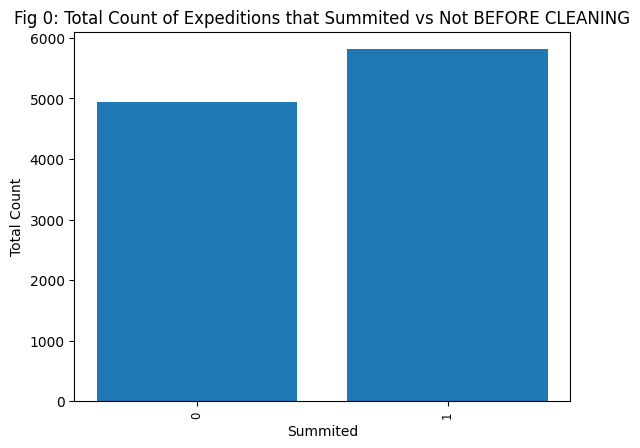

In [15]:
himalaya_table = MyPyTable()
himalaya_table.load_from_file("data/322-Final-Dataset.csv")

# Converting the SMTMEMBERS row to binary values as this will be 
#   what we will use for predictions
himalaya_table.convert_row_to_binary("SUMMIT_SUCCESS", 0.0)
himalaya_table = himalaya_table.combine_boolean_rows("SKI", "PARAPENTE", "TRUE")

summit_col = eda_utils.get_column(himalaya_table.data,himalaya_table.column_names,"SUMMIT_SUCCESS")
eda_utils.generate_frequency_diagram(summit_col,"Summited", "Total Count", "Fig 0: Total Count of Expeditions that Summited vs Not BEFORE CLEANING")

# Removing all rows with missing values
himalaya_table.remove_rows_with_missing_values("")

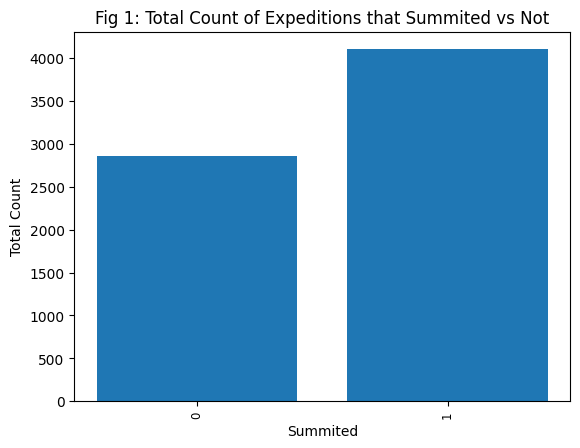

In [3]:
summit_col = eda_utils.get_column(himalaya_table.data,himalaya_table.column_names,"SUMMIT_SUCCESS")
eda_utils.generate_frequency_diagram(summit_col,"Summited", "Total Count", "Fig 1: Total Count of Expeditions that Summited vs Not")

## Data Analysis

Creating the success and failure tables:

In [4]:
success_table = MyPyTable()
success_table.column_names = himalaya_table.column_names
success_table.data = [row for row in himalaya_table.data if row[-1] == 1]

failure_table = MyPyTable()
failure_table.data = [row for row in himalaya_table.data if row[-1] == 0]
failure_table.column_names = himalaya_table.column_names

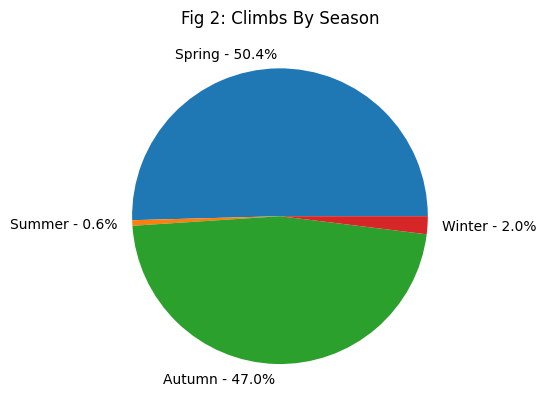

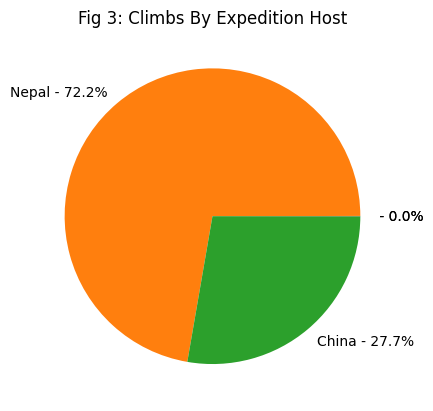

In [17]:
eda_utils.generate_pie_chart_from_column(himalaya_table, "SEASON", ['Spring', 'Summer', 'Autumn', 'Winter'], "Fig 2: Climbs By Season")
eda_utils.generate_pie_chart_from_column(himalaya_table, "HOST", ['', 'Nepal', 'China', ''], "Fig 3: Climbs By Expedition Host")

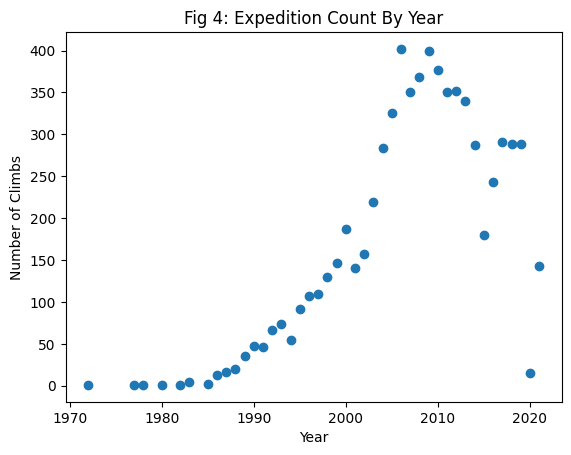

In [6]:
eda_utils.generate_scatter_plot(himalaya_table, "YEAR", "Year", "Number of Climbs", "Fig 4: Expedition Count By Year")

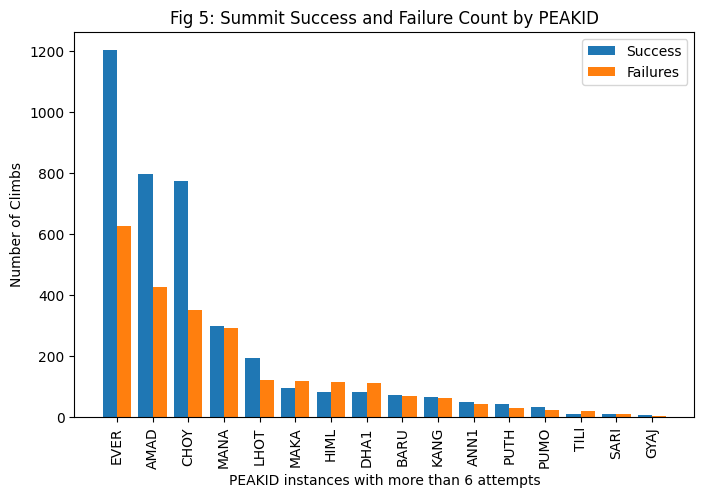

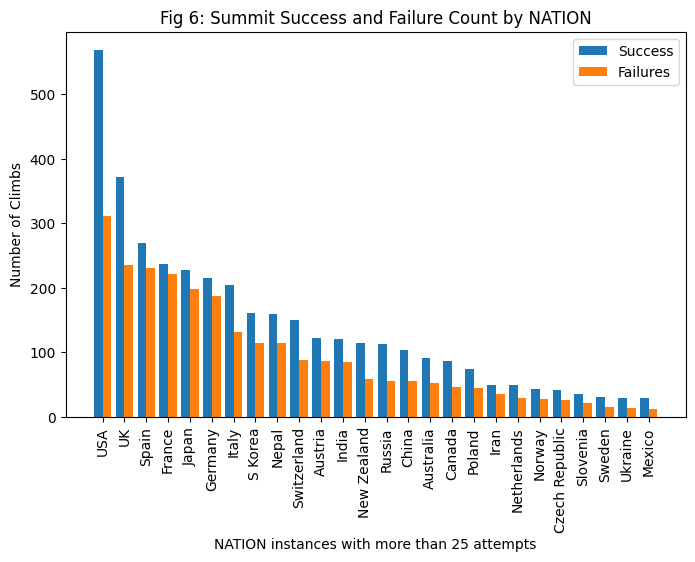

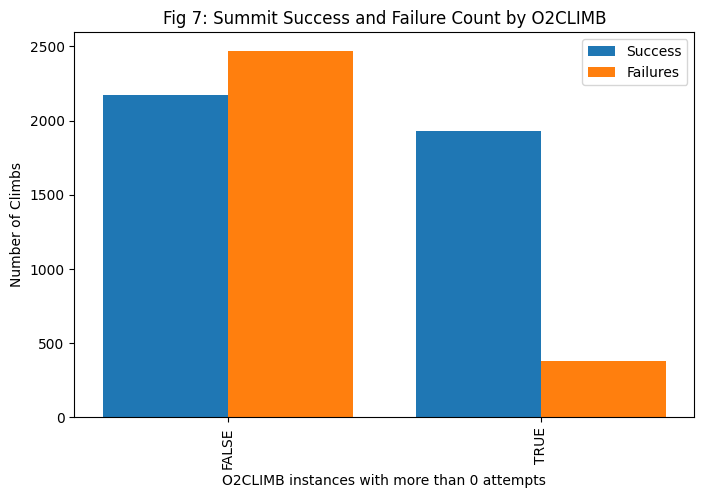

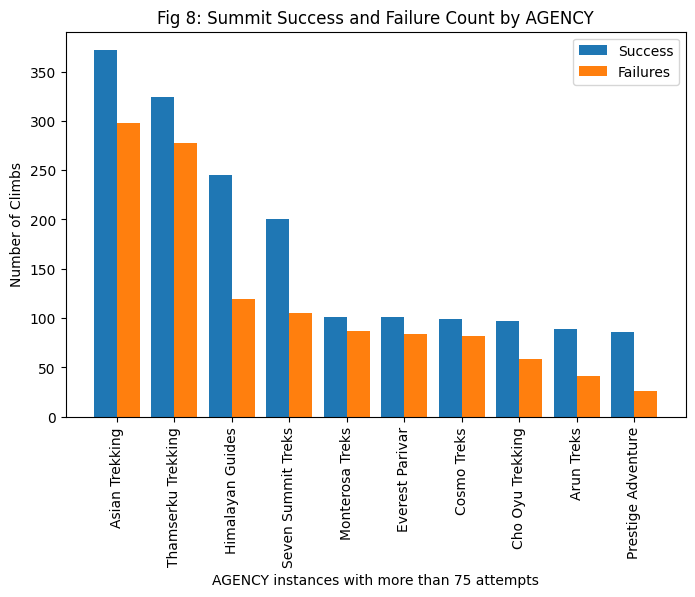

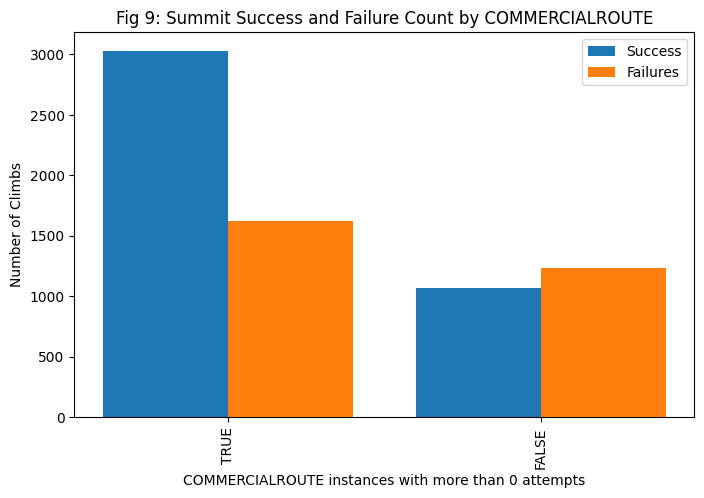

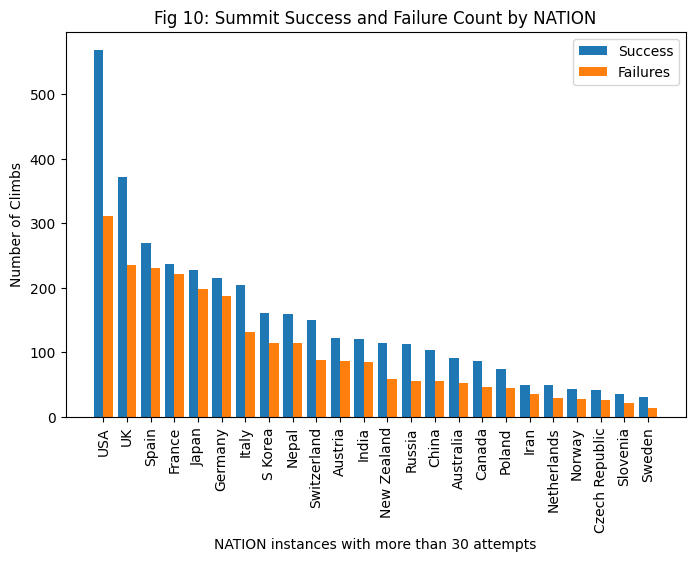

In [7]:
eda_utils.make_success_and_failure_chart(success_table, failure_table, "PEAKID", 6, 5)
eda_utils.make_success_and_failure_chart(success_table, failure_table, "NATION", 25, 6)
eda_utils.make_success_and_failure_chart(success_table, failure_table, "O2CLIMB", 0, 7)
eda_utils.make_success_and_failure_chart(success_table, failure_table, "AGENCY", 75, 8)
eda_utils.make_success_and_failure_chart(success_table, failure_table, "COMMERCIALROUTE", 0, 9)
eda_utils.make_success_and_failure_chart(success_table, failure_table, "NATION", 30, 10)


### Data Analysis Results:
Looking deeper into the data we are using proved to be quite interesting. The very first that that was surprising was that the amount of successes was higher than the amount of failures (Fig 1). This is unexpected as media surrounding these mountains often promote their difficulty. Moving on it can be seen that well over 90% of climbs happened in the Spring or Autumn. Again, this was unexpceted as intuitivley summer seems like it would be the most ideal time to climb these mountains based on the weather being more favorable. Figure 4 shows how the number of expeditions has changed over time. This is one of the more interesting graphs in this project as it clearly shows the rise in popularity that mountaineering has undergone. With gear, travel, and expedition companies becoming cheaper and more accessible and routes have become more established it tracks that there are more expeditions going out each year. The graph shows a peak in expedition counts around 2009 which, without going into too much detail, tracks with the trends of mountaineering. The early 2000's was really when this style of climbing grew in popularity and accessiblilty. Any CEO or high paid individual could (and can) pay their way to the top of these peaks and with more companies offering expedition guidiing, the market has really begun to boom. 


Moving onto figures 5-10, we can see the relationship between various attributes and the number of successes and failures they represent. Perhaps the most interesting of these are figure 5 and figure 9. Figure 5 shows the successes and failures of peaks with over 6 expeditions. This graph is so interesting as you can see that the more popular mountains have a higher rate of success. This shows a positive feedback cycle where more popular peaks are easier to climb and since they are climbed more often they becomre more established and documented and therefore are becoming easier to climb. Mountains like Makalu (MAKA) are lesser known but still popular among more die-hard mountaineers since they are more difficult as can be seen with the higher failure rate. Figure 9 shows the use of oxygen and the role it plays in climbing. Many of these mountains tower well over 20,000ft, at which point there is so little oxygen in the atmosphere that climbers often will supplement their oxygen intake. This clearly helps them as fig 9 shows that the expeditions that use oxygen are much more likely to succeed than those who do not. Those who do not have a far greater amount of failures than successes due to the sheer difficulty of operating with such little oxygen. This puts famous mountaineering feats, like climbing all 14 peaks over 28,000ft, much more impressive. 

## Creating Training Data (with and without attribute selection)

In [8]:
X_train = [row[:-1] for row in himalaya_table.data]
y_train = [row[-1] for row in himalaya_table.data]
# Only using YEAR, SEASON, HOST, 02CLIMB, COMMERCIALROUTE:
select_X_train = [[row[1], row[2], row[3], row[10], row[14]] for row in himalaya_table.data]

## Naive Bayes Classifying:

In [9]:
himalaya_nb_classifier = MyNaiveBayesClassifier()

classifier_stats = myutils.get_classifier_stats(himalaya_nb_classifier, X_train, y_train, 10)
select_classifier_stats = myutils.get_classifier_stats(himalaya_nb_classifier, select_X_train, y_train, 10)

myutils.print_stats("Naive Bayes Results %", classifier_stats)
myutils.print_stats("Naive Bayes Results %\nTrained on YEAR, SEASON, HOST, 02CLIMB, COMMERCIALROUTE ", select_classifier_stats)

Naive Bayes Results %
Accuracy:  59.3
Error Rate:  40.699999999999996
Precision:  52.2
Recall:  9.4
F1 Score:  16.0
Naive Bayes Results %
Trained on YEAR, SEASON, HOST, 02CLIMB, COMMERCIALROUTE 
Accuracy:  65.10000000000001
Error Rate:  34.9
Precision:  57.9
Recall:  55.400000000000006
F1 Score:  56.599999999999994


## Decision Tree Classifying:

In [10]:
himalaya_nb_classifier = MyDecisionTreeClassifier()

classifier_stats = myutils.get_classifier_stats(himalaya_nb_classifier, X_train, y_train, 10)
select_classifier_stats = myutils.get_classifier_stats(himalaya_nb_classifier, select_X_train, y_train, 10)

myutils.print_stats("Decision Tree Results %\nTrained on ALL attributes", classifier_stats)
myutils.print_stats("Decision Tree Results %\nTrained on YEAR, SEASON, HOST, 02CLIMB, COMMERCIALROUTE", select_classifier_stats)

Decision Tree Results %
Trained on ALL attributes
Accuracy:  16.400000000000002
Error Rate:  83.6
Precision:  48.9
Recall:  12.9
F1 Score:  20.4
Decision Tree Results %
Trained on YEAR, SEASON, HOST, 02CLIMB, COMMERCIALROUTE
Accuracy:  63.5
Error Rate:  36.5
Precision:  54.300000000000004
Recall:  74.0
F1 Score:  61.7


## Random Forest Classification:

In [11]:
himalaya_rf = MyRandomForrestClassifier(10, 4, 2)

classifier_stats = myutils.get_classifier_stats(himalaya_rf, X_train, y_train, 10)
select_classifier_stats = myutils.get_classifier_stats(himalaya_rf, select_X_train, y_train, 10)

myutils.print_stats("Random Forest Results %\nTrained on ALL attributes", classifier_stats)
myutils.print_stats("Random Forest Results %\nTrained on YEAR, SEASON, HOST, 02CLIMB, COMMERCIALROUTE", select_classifier_stats)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

## Association Rule Miner

In [ ]:
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyAssociationRuleMiner
from copy import deepcopy

rule_miner = MyAssociationRuleMiner()

himalayan_X = deepcopy(himalaya_table.data)
himalayan_X = myutils.prepend_attribute_label(himalayan_X, himalaya_table.column_names)

rule_miner.fit(himalayan_X)
rule_miner.print_association_rules()

  #  association rule                            support    confidence      lift
---  ----------------------------------------  ---------  ------------  --------
  0  IF CAMPS=3.0 THEN O2UNKWN=FALSE            0.304254      0.999528  1.00097
  1  IF CAMPS=3.0 THEN SKI=False                0.294625      0.967894  0.990675
  2  IF COMMERCIALROUTE=FALSE THEN HOST=1.0     0.323225      0.976128  1.35108
  3  IF COMMERCIALROUTE=FALSE THEN SKI=False    0.325093      0.981771  1.00488
  4  IF HOST=2.0 THEN COMMERCIALROUTE=TRUE      0.269474      0.97251   1.45396
  5  IF PEAKID=EVER THEN COMMERCIALROUTE=TRUE   0.254096      0.966648  1.4452
  6  IF COMMERCIALROUTE=TRUE THEN SKI=False     0.651911      0.974645  0.997585
  7  IF HOST=1.0 THEN O2SLEEP=FALSE             0.589825      0.816391  1.02111
  8  IF HOST=1.0 THEN O2UNKWN=FALSE             0.721184      0.99821   0.999646
  9  IF HOST=1.0 THEN SKI=False                 0.710405      0.98329   1.00643
 10  IF STDROUTE=FALSE THEN HOST=1.0

In [ ]:
rule_miner = MyAssociationRuleMiner()

himalayan_X = deepcopy(himalaya_table.data)
himalayan_X = myutils.prepend_attribute_label(himalayan_X, himalaya_table.column_names)
himalayan_X = [[row[0],row[1], row[2], row[3],row[10], row[14], row[16]] for row in himalayan_X]

rule_miner.fit(himalayan_X)
rule_miner.print_association_rules()

  #  association rule                            support    confidence     lift
---  ----------------------------------------  ---------  ------------  -------
  0  IF COMMERCIALROUTE=FALSE THEN HOST=1.0     0.323225      0.976128  1.35108
  1  IF HOST=2.0 THEN COMMERCIALROUTE=TRUE      0.269474      0.97251   1.45396
  2  IF PEAKID=EVER THEN COMMERCIALROUTE=TRUE   0.254096      0.966648  1.4452
  3  IF SEASON=3.0 THEN O2CLIMB=FALSE           0.391636      0.833079  1.24765
  4  IF SUMMIT_SUCCESS=0 THEN O2CLIMB=FALSE     0.355275      0.866153  1.29718
  5  IF O2CLIMB=TRUE THEN SUMMIT_SUCCESS=1      0.277379      0.834775  1.41529


In [ ]:
rule_miner = MyAssociationRuleMiner(0.2,0.97)

himalayan_X = deepcopy(himalaya_table.data)
himalayan_X = myutils.prepend_attribute_label(himalayan_X, himalaya_table.column_names)
himalayan_X = [[row[0],row[1], row[2], row[3],row[4],row[5],
                row[7],row[8],row[9],row[10],row[11],
                row[13],row[14],row[16]] for row in himalayan_X]


rule_miner.fit(himalayan_X)
rule_miner.print_association_rules()

  #  association rule                          support    confidence     lift
---  --------------------------------------  ---------  ------------  -------
  0  IF COMMERCIALROUTE=FALSE THEN HOST=1.0   0.323225      0.976128  1.35108
  1  IF HOST=2.0 THEN COMMERCIALROUTE=TRUE    0.269474      0.97251   1.45396
  2  IF TOTHIRED=0.0 THEN O2SLEEP=FALSE       0.301667      0.974466  1.21883


In [ ]:
print(himalaya_table.column_names)

['PEAKID', 'YEAR', 'SEASON', 'HOST', 'NATION', 'BCDATE', 'SKI', 'CAMPS', 'TOTMEMBERS', 'TOTHIRED', 'O2CLIMB', 'O2SLEEP', 'O2UNKWN', 'AGENCY', 'COMMERCIALROUTE', 'STDROUTE', 'SUMMIT_SUCCESS']


In [ ]:
rule_miner = MyAssociationRuleMiner(0.3,0.75)

himalayan_X = deepcopy(himalaya_table.data)
himalayan_X = myutils.prepend_attribute_label(himalayan_X, himalaya_table.column_names)
himalayan_X = [[row[0],row[1], row[2], row[3],row[4],row[5],
                row[7],row[8],row[9],row[10],row[11],
                row[13],row[14],row[16]] for row in himalayan_X]


rule_miner.fit(himalayan_X)
rule_miner.print_association_rules()

KeyboardInterrupt: 